In [1]:
import os
import torch
from torchvision import datasets
import torchvision
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import ImageFile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.ion()

In [86]:
batch_size = 5
model_path = "C:/Users/thend/Desktop/Pratik/Face_features/Models/"
model_name = "skinclassifier_oncpu.pt"
model_path = model_path + model_name
num_workers = 0


transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [87]:
train_set = 'C:/Users/thend/Desktop/Pratik/Face_features/Dataset/Training'
valid_set = 'C:/Users/thend/Desktop/Pratik/Face_features/Dataset/Validation'

train_data = datasets.ImageFolder(train_set, transform=transform)
valid_data = datasets.ImageFolder(valid_set, transform=transform)

a = train_data.class_to_idx
print(a)
# print(a["Train"])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders = {
    'train': train_loader,
    'valid': valid_loader
}

{'Acne': 0, 'Pale_skintone': 1, 'Pigmentation': 2, 'Pore_Quality': 3, 'Wrinkled': 4, 'dark_skintone': 5, 'light_skintone': 6, 'medium_skintone': 7}


In [88]:
train_data

Dataset ImageFolder
    Number of datapoints: 104
    Root location: C:/Users/thend/Desktop/Pratik/Face_features/Dataset/Training
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [89]:
valid_data

Dataset ImageFolder
    Number of datapoints: 46
    Root location: C:/Users/thend/Desktop/Pratik/Face_features/Dataset/Validation
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [90]:
class_names = ['Acne', 'Pale_skintone', 'Pigmentation', 'Pore_Quality', 'Wrinkled', 'dark_skintone', 'light_skintone', 'medium_skintone']
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Acne', 'Pale_skintone', 'Pigmentation', 'Pore_Quality', 'Wrinkled', 'dark_skintone', 'light_skintone', 'medium_skintone']


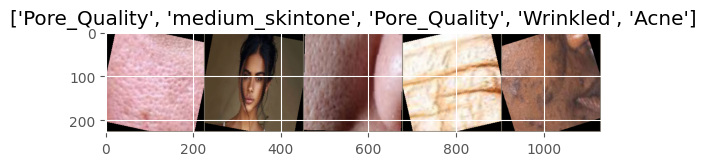

In [91]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = loaders["train"].dataset.classes
print(class_names)

# Get a batch of training data
inputs, classes = next(iter(train_loader))
# print(inputs, classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [92]:
model = models.resnet50(pretrained=True)


# use_cuda = torch.cuda.is_available()

# if use_cuda:
    # model = model.cuda()

# model

c:\Users\thend\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\thend\.conda\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [93]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Sequential(torch.nn.Linear(2048,128),
                                      torch.nn.ReLU(),
                                       torch.nn.Linear(128,8),
                                       torch.nn.Softmax()
                                      )

# for param in model.fc.parameters():
#     param.requires_grad = True
    
# if use_cuda:
#     model_transfer = model.cuda()
# else:
#     print("entered else")
model_transfer = model

In [94]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transfer.fc.parameters(), lr=0.0005)

In [95]:
n_epochs = 50

train_accuracy_list = []
train_loss_list = []
valid_accuracy_list = []
valid_loss_list = []

def train(n_epochs, loader, model, optimizer, criterion, save_path):
    
    valid_loss_min = np.Inf
       
    for epoch in range(1, (n_epochs+1)):
        
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        
        model.train()
        
        for batch_idx, (data, target) in enumerate(loader['train']):
            
            # if use_cuda:
            #     data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_acc = train_acc + torch.sum(preds == target.data)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            model.eval()
        for batch_idx, (data, target) in enumerate(loader['valid']):

            # if use_cuda:
            #     data, target = data.cuda(), target.cuda()

            output = model(data)
            _, preds = torch.max(output, 1)
            loss = criterion(output, target)
            
            valid_acc = valid_acc + torch.sum(preds == target.data)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        train_loss = train_loss/len(loader['train'].dataset)
        valid_loss = valid_loss/len(loader['valid'].dataset)
        train_acc = train_acc/len(loader['train'].dataset)
        valid_acc = valid_acc/len(loader['valid'].dataset)
        
        train_accuracy_list.append(train_acc)
        train_loss_list.append(train_loss)
        valid_accuracy_list.append(valid_acc)
        valid_loss_list.append(valid_loss)
        
        print('Epoch: {} \tTraining Acc: {:6f} \tTraining Loss: {:6f} \tValidation Acc: {:6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_acc,
            train_loss,
            valid_acc,
            valid_loss
            ))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model, save_path)
            valid_loss_min = valid_loss  
            
    return model

In [96]:
print(model_path)
model = train(n_epochs, loaders, model, optimizer, criterion, model_path)

C:/Users/thend/Desktop/Pratik/Face_features/Models/skinclassifier_oncpu.pt


c:\Users\thend\.conda\envs\torch\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1 	Training Acc: 0.163462 	Training Loss: 0.019817 	Validation Acc: 0.521739 	Validation Loss: 0.039412
Validation loss decreased (inf --> 0.039412).  Saving model ...
Epoch: 2 	Training Acc: 0.288462 	Training Loss: 0.018928 	Validation Acc: 0.565217 	Validation Loss: 0.040145
Epoch: 3 	Training Acc: 0.346154 	Training Loss: 0.018465 	Validation Acc: 0.586957 	Validation Loss: 0.037001
Validation loss decreased (0.039412 --> 0.037001).  Saving model ...
Epoch: 4 	Training Acc: 0.442308 	Training Loss: 0.018236 	Validation Acc: 0.565217 	Validation Loss: 0.038062
Epoch: 5 	Training Acc: 0.451923 	Training Loss: 0.017822 	Validation Acc: 0.521739 	Validation Loss: 0.039169
Epoch: 6 	Training Acc: 0.538462 	Training Loss: 0.017644 	Validation Acc: 0.608696 	Validation Loss: 0.036860
Validation loss decreased (0.037001 --> 0.036860).  Saving model ...
Epoch: 7 	Training Acc: 0.576923 	Training Loss: 0.017415 	Validation Acc: 0.673913 	Validation Loss: 0.038173
Epoch: 8 	Training Ac

Last loss:  tensor(0.0148)


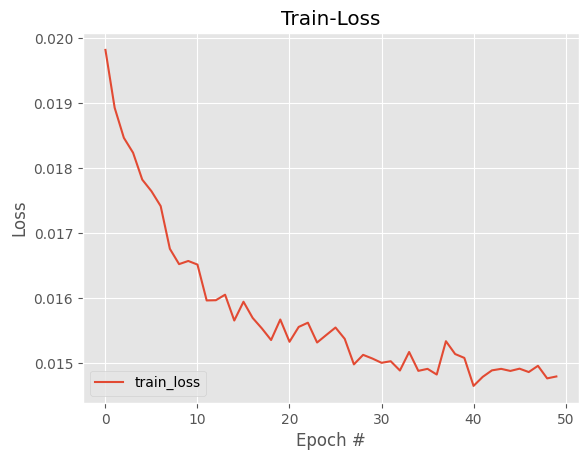

In [97]:
plt.style.use("ggplot")
plt.figure()
loss_lis = [tensor.item() for tensor in train_loss_list]

""" The training loss should decrease over time as the model learns from the data. 
However, a very low training loss doesn't necessarily mean the model 
will perform well on new, unseen data, as it may have overfit the training data"""

print("Last loss: ", train_loss_list[-1])
plt.plot(loss_lis, label="train_loss")
plt.title("Train-Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")


Train accuracy mean:  tensor(0.6704)
Valid accuracy mean:  tensor(0.6343)


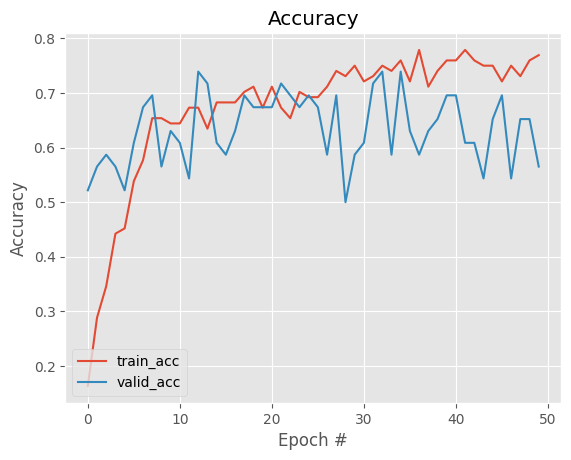

In [98]:
plt.style.use("ggplot")
plt.figure()

print()
train_acc_lis = [tensor.item() for tensor in train_accuracy_list]
valid_acc_lis = [tensor.item() for tensor in valid_accuracy_list]

mean_accuracy_train = torch.tensor(train_accuracy_list)
mean_accuracy_train = mean_accuracy_train.mean()
print("Train accuracy mean: ", mean_accuracy_train)
mean_accuracy_valid = torch.tensor(valid_accuracy_list)
mean_accuracy_valid = mean_accuracy_valid.mean()
print("Valid accuracy mean: ", mean_accuracy_valid)

plt.plot(train_acc_lis, label="train_acc")
plt.plot(valid_acc_lis, label="valid_acc")

plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

In [100]:
from PIL import Image

class_names = ['Acne', 'Pale_skintone', 'Pigmentation', 'Pore_Quality', 'Wrinkled', 'dark_skintone', 'light_skintone', 'medium_skintone']

def predict(image, model_path):
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    # image = image.cuda()

    # loaded_model = models.resnet50()
    loaded_model = torch.load(model_path)
    loaded_model.eval()

    # model.load_state_dict(torch.load(model_path))
    # model.eval()

    pred = loaded_model(image)
    idx = torch.argmax(pred)
    print(idx, "idx")
    prob = pred[0][idx].item()*100

    # print(class_names[idx], "class_names[idx]")
    
    return class_names[idx], prob

In [ ]:
def test(image_path, model_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.show()

    prediction, prob = predict(img, model_path=model_path)
    print(prediction, prob)


test(image_path="C:/Users/thend/Downloads/download.jpg", model_path="C:/Users/thend/Desktop/Pratik/Face_features/Models/skinclassifier_oncpu.pt")

In [73]:
import torch
from torch import nn
from torchvision import transforms
from PIL import Image

def load_model(model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict_image(model_path, image_path, prediction_transform):
    # Load the model
    model = load_model(model_path)

    # Read and transform the image
    image = Image.open(image_path).convert("RGB")
    transformed_image = prediction_transform(image)
    transformed_image = transformed_image.unsqueeze(0)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(transformed_image)

    # Get predicted class
    _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

# Example usage:
model_path = 'C:/Users/thend/Desktop/Pratik/Face_features/Models/Modelsskinclassifier.pt'
image_path = 'C:/Users/thend/Downloads/download (1).jpg'
prediction_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

predicted_class = predict_image(model_path, image_path, prediction_transform)
print("Predicted Class:", predicted_class)

Predicted Class: 4


In [109]:
pip install onnx

^C
Note: you may need to restart the kernel to use updated packages.


  Using cached onnx-1.15.0.tar.gz (12.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached protobuf-4.25.2-cp310-abi3-win_amd64.whl.metadata (541 bytes)
Using cached protobuf-4.25.2-cp310-abi3-win_amd64.whl (413 kB)
Failed to build onnx


  error: subprocess-exited-with-error
  
  × Building wheel for onnx (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [9251 lines of output]
      fatal: not a git repository (or any of the parent directories): .git
      running bdist_wheel
      running build
      running build_py
      copying onnx\checker.py -> build\lib.win-amd64-cpython-312\onnx
      copying onnx\compose.py -> build\lib.win-amd64-cpython-312\onnx
      copying onnx\external_data_helper.py -> build\lib.win-amd64-cpython-312\onnx
      copying onnx\gen_proto.py -> build\lib.win-amd64-cpython-312\onnx
      copying onnx\helper.py -> build\lib.win-amd64-cpython-312\onnx
      copying onnx\hub.py -> build\lib.win-amd64-cpython-312\onnx
      copying onnx\inliner.py -> build\lib.win-amd64-cpython-312\onnx
      copying onnx\mapping.py -> build\lib.win-amd64-cpython-312\onnx
      copying onnx\numpy_helper.py -> build\lib.win-amd64-cpython-312\onnx
      copying onnx\parser.py -> build\lib.win-amd64-c